In [1]:
# My attempt at a temporal GNN

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch_geometric.data import Data
import networkx as nx
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

KeyboardInterrupt: 

In [ ]:
# check device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda:0


In [166]:
torch.cuda.is_available()

True

In [167]:
df = pd.read_csv('../../data/cleaned/cleaned_vessel_calls.csv')

In [168]:
# Preprocess the dataframe
df["arrivalDate"] = pd.to_datetime(df["arrivalDate"])
df["sailingDate"] = pd.to_datetime(df["sailingDate"])
df["duration"] = (df["sailingDate"] - df["arrivalDate"]) / pd.Timedelta(days=1)
df = df.dropna()

In [169]:
# Sort and filter data
df.sort_values(by=["IMO", "arrivalDate"], inplace=True)
df['next_unlocode'] = df.groupby('IMO')['place.unlocode'].shift(-1)
df['is_last_imo'] = df['IMO'] != df['IMO'].shift(-1)
df = df[~df["is_last_imo"]]
df = df[df["Event_Type"] != "ARRIVAL"]

In [170]:
# Drop unnecessary columns
df = df.drop(columns=["is_last_imo", "Event_Type", "Timestamp", "vessel.vesselName", "IMO"])

# Rename columns for consistency
df = df.rename(columns={'place.unlocode': 'current_unlocode', 'place.placeName': 'port_name', 'vessel.vesselType': 'vessel_type', 'place.placeType': 'place_type', 'place.countryName': 'country_name', 'arrivalDate': 'arrival_date', 'sailingDate': 'sailing_date'})

In [171]:
df.head(5)

,arrival_date,sailing_date,port_name,current_unlocode,place_type,country_name,vessel_type,duration,next_unlocode
314761,2023-01-18 14:10:05,2023-01-26 04:05:00,Los Angeles,USLAX,Port,United States of America,Vessel Type (unspecified),7.579803,CNJGY
314763,2023-02-22 07:17:58,2023-02-23 18:56:16,Jiangyin,CNJGY,Port,People's Republic of China,Vessel Type (unspecified),1.484931,CNTXG
314765,2023-03-02 16:00:39,2023-03-03 12:31:09,Tianjin Xingang Port,CNTXG,Port,People's Republic of China,Vessel Type (unspecified),0.854514,CNQAW
314767,2023-03-04 21:02:13,2023-03-05 11:45:29,Qianwan,CNQAW,Sub Port,People's Republic of China,Vessel Type (unspecified),0.613380,CNMSN
314769,2023-03-06 23:30:18,2023-03-08 00:00:46,Meishan,CNMSN,Sub Port,People's Republic of China,Vessel Type (unspecified),1.021157,CNNSA


In [172]:
# Encode categorical features
label_encoders = {}
label_cols = ['port_name', 'place_type', 'country_name', 'vessel_type']
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [173]:
# Encode the current and next unlocodes
all_ports = pd.concat([df['current_unlocode'], df['next_unlocode']])

# Create unique identifiers for each port
unique_ports = all_ports.unique()
port_to_id = {port: i for i, port in enumerate(unique_ports)}

df['current_unlocode'] = df['current_unlocode'].map(port_to_id)
df['next_unlocode'] = df['next_unlocode'].map(port_to_id)

# Print the first few rows of the DataFrame to verify the encoding
print(df.head(5))

              arrival_date        sailing_date  port_name  current_unlocode  \
314761 2023-01-18 14:10:05 2023-01-26 04:05:00        840                 0   
314763 2023-02-22 07:17:58 2023-02-23 18:56:16        658                 1   
314765 2023-03-02 16:00:39 2023-03-03 12:31:09       1583                 2   
314767 2023-03-04 21:02:13 2023-03-05 11:45:29       1279                 3   
314769 2023-03-06 23:30:18 2023-03-08 00:00:46        908                 4   

        place_type  country_name  vessel_type  duration  next_unlocode  
314761           1           163            4  7.579803              1  
314763           1           104            4  1.484931              2  
314765           1           104            4  0.854514              3  
314767           2           104            4  0.613380              4  
314769           2           104            4  1.021157              5  


In [174]:
# Apply MinMax Scaling
scaler = MinMaxScaler()
df[['port_name', 'place_type', 'country_name', 'vessel_type','duration']] = scaler.fit_transform(df[['port_name', 'place_type', 'country_name', 'vessel_type', 'duration']])
df.head(5)

,arrival_date,sailing_date,port_name,current_unlocode,place_type,country_name,vessel_type,duration,next_unlocode
314761,2023-01-18 14:10:05,2023-01-26 04:05:00,0.477002,0,0.5,0.970238,0.222222,0.026696,1
314763,2023-02-22 07:17:58,2023-02-23 18:56:16,0.373651,1,0.5,0.619048,0.222222,0.005230,2
314765,2023-03-02 16:00:39,2023-03-03 12:31:09,0.898921,2,0.5,0.619048,0.222222,0.003010,3
314767,2023-03-04 21:02:13,2023-03-05 11:45:29,0.726292,3,1.0,0.619048,0.222222,0.002160,4
314769,2023-03-06 23:30:18,2023-03-08 00:00:46,0.515616,4,1.0,0.619048,0.222222,0.003596,5


In [175]:
# Segment data into bi-weekly intervals
df['bi_weekly'] = df['arrival_date'].dt.to_period('2W')

# Basic statistics
node_counts = df.groupby('bi_weekly')['current_unlocode'].nunique()
edge_counts = df.groupby('bi_weekly').size()
label_counts = df['next_unlocode'].value_counts()

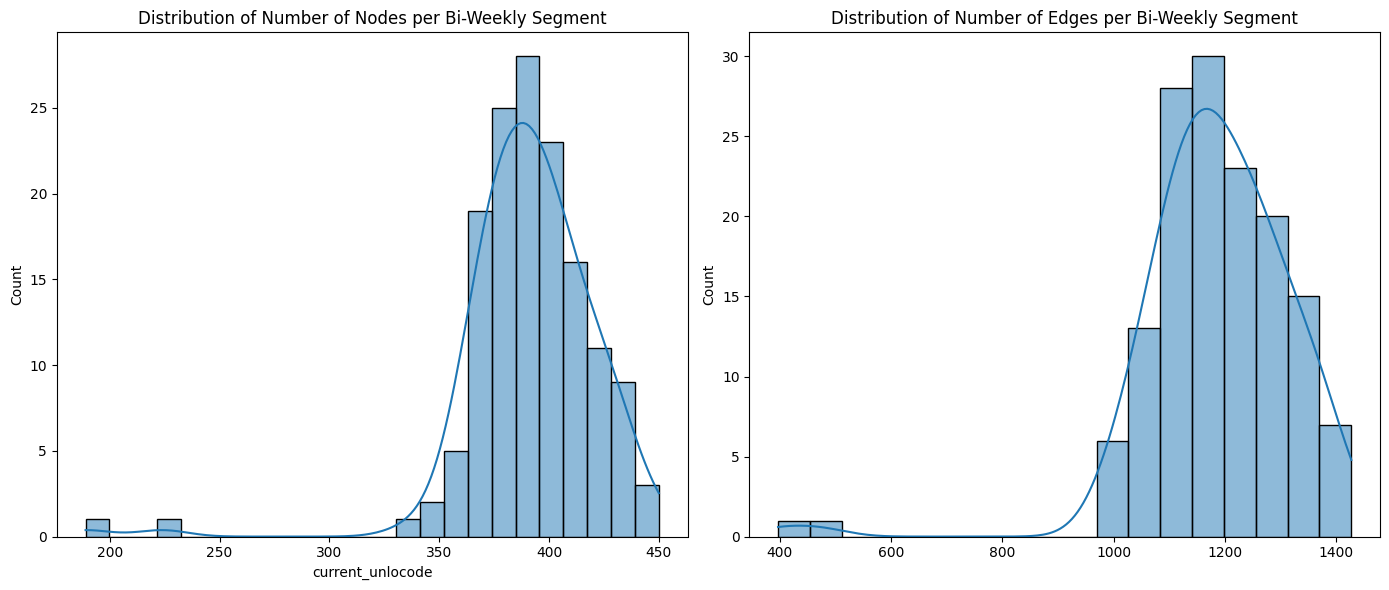

Average number of nodes per bi-weekly segment: 391.2361111111111
Average number of edges per bi-weekly segment: 1185.7777777777778
Label distribution:
next_unlocode
7       8981
29      3343
19      3192
85      3005
49      2793
        ... 
1562       1
1561       1
1058       1
1559       1
1765       1
Name: count, Length: 1771, dtype: int64


In [176]:
# Plotting the distributions
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(node_counts, kde=True)
plt.title('Distribution of Number of Nodes per Bi-Weekly Segment')

plt.subplot(1, 2, 2)
sns.histplot(edge_counts, kde=True)
plt.title('Distribution of Number of Edges per Bi-Weekly Segment')

plt.tight_layout()
plt.show()

# Print basic statistics
print(f"Average number of nodes per bi-weekly segment: {node_counts.mean()}")
print(f"Average number of edges per bi-weekly segment: {edge_counts.mean()}")
print(f"Label distribution:\n{label_counts}")

In [177]:
# Function to construct a temporal graph
def construct_temporal_graph(df):
    G = nx.DiGraph()
    node_features = {}
    
    for _, row in df.iterrows():
        node_id = row['current_unlocode']
        node_features[node_id] = [row['country_name'], row['place_type']]
        
        G.add_node(node_id)
        direction = hash(f"{node_id}_{row['next_unlocode']}")
        G.add_edge(node_id, row['next_unlocode'], 
                   duration=row['duration'], 
                   direction=direction, 
                   vessel_type=row['vessel_type'])
    
    # Remove nodes without edges
    isolated_nodes = [node for node in G.nodes if G.degree(node) == 0]
    G.remove_nodes_from(isolated_nodes)
    
    # Add missing features
    for node in G.nodes:
        if node not in node_features:
            matching_rows = df[df['current_unlocode'] == node]
            if not matching_rows.empty:
                row = matching_rows.iloc[0]
                node_features[node] = [row['country_name'], row['place_type']]
    
    return G, node_features

# Create temporal graphs for each bi-weekly segment
temporal_graphs = {}
node_features_dict = {}
for period, group in df.groupby('bi_weekly'):
    G, node_features = construct_temporal_graph(group)
    temporal_graphs[period] = G
    node_features_dict[period] = node_features

# Example temporal graph
sample_period = list(temporal_graphs.keys())[0]
G_sample = temporal_graphs[sample_period]
print(f"Graph for period {sample_period}")
print(f"Nodes: {G_sample.nodes(data=True)}")
print(f"Edges: {G_sample.edges(data=True)}")

# Prepare data for PyG and PyTorch Temporal
def prepare_data(G, node_features):
    edge_index = []
    edge_attr = []
    x = []
    for node, features in node_features.items():
        x.append(features)
    for src, dst, features in G.edges(data=True):
        edge_index.append([src, dst])
        edge_attr.append([features['duration'], features['direction'], features['vessel_type']])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    x = torch.tensor(x, dtype=torch.float)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# Example data preparation
data = prepare_data(G_sample, node_features_dict[sample_period])
print(data)

Graph for period 2020-12-28/2021-01-03
Nodes: [(11, {}), (31, {}), (149, {}), (196, {}), (197, {}), (85, {}), (91, {}), (200, {}), (86, {}), (32, {}), (313, {}), (458, {}), (23, {}), (100, {}), (230, {}), (66, {}), (92, {}), (82, {}), (94, {}), (168, {}), (550, {}), (109, {}), (114, {}), (481, {}), (78, {}), (68, {}), (126, {}), (69, {}), (328, {}), (330, {}), (213, {}), (659, {}), (167, {}), (7, {}), (520, {}), (24, {}), (664, {}), (98, {}), (438, {}), (49, {}), (609, {}), (521, {}), (319, {}), (88, {}), (120, {}), (87, {}), (3, {}), (9, {}), (8, {}), (55, {}), (505, {}), (36, {}), (2, {}), (75, {}), (787, {}), (620, {}), (90, {}), (166, {}), (83, {}), (792, {}), (54, {}), (73, {}), (248, {}), (538, {}), (115, {}), (116, {}), (673, {}), (103, {}), (569, {}), (44, {}), (153, {}), (33, {}), (245, {}), (534, {}), (39, {}), (0, {}), (29, {}), (30, {}), (142, {}), (141, {}), (89, {}), (840, {}), (718, {}), (522, {}), (1063, {}), (6, {}), (1039, {}), (456, {}), (225, {}), (933, {}), (663, {

In [178]:
import torch.nn as nn
from torch_geometric.nn import GCNConv

class TemporalGNN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TemporalGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)
        
    def forward(self, data):
        x, edge_index, edge_attr = data.x.to(device), data.edge_index.to(device), data.edge_attr.to(device)
        x = self.conv1(x, edge_index)
        x = nn.functional.relu(x)
        x = self.conv2(x, edge_index)
        return x

model = TemporalGNN(in_channels=data.x.shape[1], out_channels=len(label_counts)).to(device)

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

criterion = FocalLoss()

# Example training loop
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Split data into training and testing
num_periods = len(temporal_graphs)
train_size = int(0.8 * num_periods)
train_periods = list(temporal_graphs.keys())[:train_size]
test_periods = list(temporal_graphs.keys())[train_size:]

train_data = [prepare_data(temporal_graphs[period], node_features_dict[period]) for period in train_periods]
test_data = [prepare_data(temporal_graphs[period], node_features_dict[period]) for period in test_periods]

# Combine data into a single batch
def combine_data(data_list):
    combined_edge_index = torch.cat([data.edge_index for data in data_list], dim=1)
    combined_edge_attr = torch.cat([data.edge_attr for data in data_list], dim=0)
    combined_x = torch.cat([data.x for data in data_list], dim=0)
    return Data(x=combined_x, edge_index=combined_edge_index, edge_attr=combined_edge_attr)

train_data = combine_data(train_data).to(device)
test_data = combine_data(test_data).to(device)

# Generate labels
def generate_labels(G_list):
    labels = []
    for G in G_list:
        for src, dst in G.edges:
            labels.append(hash(f"{src}_{dst}"))
    return torch.tensor(labels, dtype=torch.long)

train_labels = generate_labels([temporal_graphs[period] for period in train_periods]).to(device)
test_labels = generate_labels([temporal_graphs[period] for period in test_periods]).to(device)

In [179]:
# Training and testing loop with accuracy and loss tracking
num_epochs = 100
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(train_data)
    loss = criterion(out, train_labels)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Calculate training accuracy
    _, pred = out.max(dim=1)
    correct = pred.eq(train_labels).sum().item()
    accuracy = correct / train_labels.size(0)
    train_accuracies.append(accuracy)

    # Testing phase
    model.eval()
    with torch.no_grad():
        out = model(test_data)
        loss = criterion(out, test_labels)
        test_losses.append(loss.item())

        # Calculate test accuracy
        _, pred = out.max(dim=1)
        correct = pred.eq(test_labels).sum().item()
        accuracy = correct / test_labels.size(0)
        test_accuracies.append(accuracy)

    print(f'Epoch {epoch}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Test Accuracy: {test_accuracies[-1]}')

ValueError: Expected input batch_size (44396) to match target batch_size (110595).

In [ ]:
# Plotting training and testing loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(num_epochs), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.tight_layout()
plt.show()